Running on the GPU
Pipeline Start
Current Time = 08.29.22_12:59:44
1/r2 [dB]:  tensor(20.)
1/q2 [dB]:  tensor(40.)
Data Load
trainset size: torch.Size([1000, 7, 100])
cvset size: torch.Size([100, 7, 100])
testset size: torch.Size([200, 7, 100])
Evaluate Kalman Filter True
Kalman Filter - MSE LOSS: tensor(10.6706) [dB]
EKF - MSE STD: tensor(0.6801) [dB]
Inference Time: 6.781366586685181
Start KNet pipeline
KNet with full model info
Training...
0 MSE Training : tensor(234.4308) [dB] MSE Validation : tensor(234.5621) [dB]
Optimal idx: 0 Optimal : tensor(234.5621) [dB]
1 MSE Training : tensor(235.4425) [dB] MSE Validation : tensor(234.3900) [dB]
Optimal idx: 1 Optimal : tensor(234.3900) [dB]
2 MSE Training : tensor(233.9996) [dB] MSE Validation : tensor(234.3305) [dB]
diff MSE Training : tensor(-1.4430) [dB] diff MSE Validation : tensor(-0.0596) [dB]
Optimal idx: 2 Optimal : tensor(234.3305) [dB]
3 MSE Training : tensor(234.9124) [dB] MSE Validation : tensor(234.2877) [dB]
diff MSE Trainin

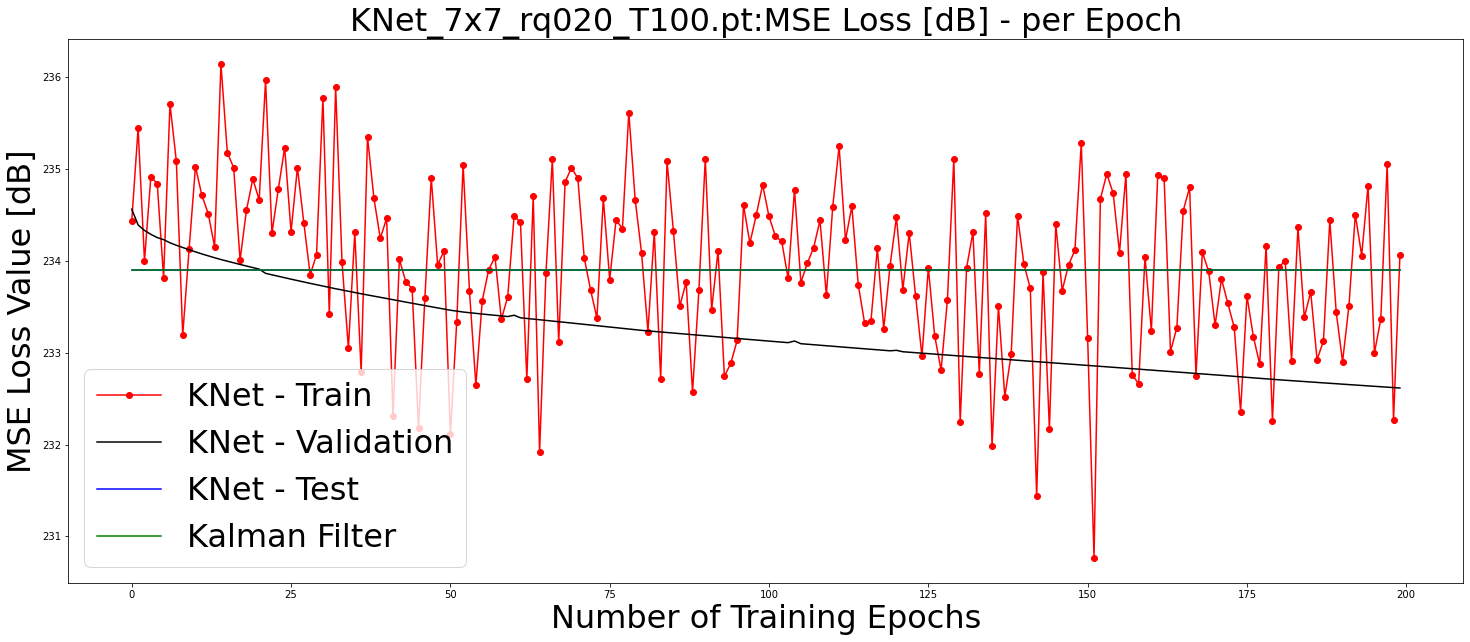

In [3]:
import torch
torch.pi = torch.acos(torch.zeros(1)).item() * 2 # which is 3.1415927410125732
import torch.nn as nn
from Linear_sysmdl import SystemModel
from Extended_data import DataGen,DataLoader,DataLoader_GPU, Decimate_and_perturbate_Data,Short_Traj_Split
from Extended_data import N_E, N_CV, N_T, F, H, T, T_test, m1_0, m2_0, m, n
from Pipeline_KF import Pipeline_KF
from KalmanNet_nn import KalmanNetNN
from datetime import datetime

from KalmanFilter_test import KFTest

from Plot import Plot_RTS as Plot

if torch.cuda.is_available():
   dev = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
   torch.set_default_tensor_type('torch.cuda.FloatTensor')
   print("Running on the GPU")
else:
   dev = torch.device("cpu")
   print("Running on the CPU")

   

print("Pipeline Start")

################
### Get Time ###
################
today = datetime.today()
now = datetime.now()
strToday = today.strftime("%m.%d.%y")
strNow = now.strftime("%H:%M:%S")
strTime = strToday + "_" + strNow
print("Current Time =", strTime)
path_results = 'RTSNet/'

####################
### Design Model ###
####################
# #r2 = torch.tensor([10,1.,0.1,1e-2,1e-3])
# r2 = torch.tensor([0.1], dtype=torch.float32)
# vdB = -20 # ratio v=q2/r2
# v = 10**(vdB/10)
# q2 = torch.mul(v,r2)


# process noise q and observation noise r
r2 = torch.tensor([1e-2])
vdB = -20 # ratio v=q2/r2
v = 10**(vdB/10)
q2 = torch.mul(v,r2)
r = torch.sqrt(r2)
q = torch.sqrt(q2)

#for index in range(0,len(r2)):

print("1/r2 [dB]: ", 10 * torch.log10(1/r2[0]))
print("1/q2 [dB]: ", 10 * torch.log10(1/q2[0]))

# True model
# r = torch.sqrt(r2[0])
# q = torch.sqrt(q2[0])
sys_model = SystemModel(F, q, H, r, T, T_test)
sys_model.InitSequence(m1_0, m2_0)

# Mismatched model
# sys_model_partialh = SystemModel(F, q, H_rotated, r, T, T_test)
# sys_model_partialh.InitSequence(m1_0, m2_0)

###################################
### Data Loader (Generate Data) ###
###################################
dataFolderName = 'Simulations/Linear_canonical/H=I' + '/'
#dataFileName = ['2x2_rq-1010_T100.pt','2x2_rq020_T100.pt','2x2_rq1030_T100.pt','2x2_rq2040_T100.pt','2x2_rq3050_T100.pt']
# print("Start Data Gen")
dataFileName = ['7x7_rq020_T100.pt']
# DataGen(sys_model, dataFolderName + dataFileName[index], T, T_test,randomInit=False)
print("Data Load")
[train_input, train_target, cv_input, cv_target, test_input, test_target] = DataLoader_GPU(dataFolderName + dataFileName[0])
print("trainset size:",train_target.size())
print("cvset size:",cv_target.size())
print("testset size:",test_target.size())

##############################
### Evaluate Kalman Filter ###
##############################
print("Evaluate Kalman Filter True")
[MSE_KF_linear_arr, MSE_KF_linear_avg, MSE_KF_dB_avg] = KFTest(sys_model, test_input, test_target)
# print("Evaluate Kalman Filter Partial")
# [MSE_KF_linear_arr_partialh, MSE_KF_linear_avg_partialh, MSE_KF_dB_avg_partialh] = KFTest(sys_model_partialh, test_input, test_target)



DatafolderName = 'Filters/Linear' + '/'
DataResultName = 'KF_'+ dataFileName[0]
torch.save({
           'MSE_KF_linear_arr': MSE_KF_linear_arr,
           'MSE_KF_dB_avg': MSE_KF_dB_avg,
           # 'MSE_KF_linear_arr_partialh': MSE_KF_linear_arr_partialh,
           # 'MSE_KF_dB_avg_partialh': MSE_KF_dB_avg_partialh,
           }, DatafolderName+DataResultName)

##################
###  KalmanNet ###
##################
print("Start KNet pipeline")
print("KNet with full model info")
modelFolder = 'KNet' + '/'
KNet_Pipeline = Pipeline_KF(strTime, "KNet", "KNet_"+ dataFileName[0])
KNet_Pipeline.setssModel(sys_model)
KNet_model = KalmanNetNN()
KNet_model.Build(sys_model)
KNet_Pipeline.setModel(KNet_model)
KNet_Pipeline.setTrainingParams(n_Epochs=200, n_Batch=30, learningRate=1E-3, weightDecay=1E-5)
print('Training...')
# KNet_Pipeline.model = torch.load(modelFolder+"model_KNet.pt")
KNet_Pipeline.NNTrain(N_E, train_input, train_target, N_CV, cv_input, cv_target)
print('Testing...')
[KNet_MSE_test_linear_arr, KNet_MSE_test_linear_avg, KNet_MSE_test_dB_avg, KNet_test] = KNet_Pipeline.NNTest(N_T, test_input, test_target)
KNet_Pipeline.PlotTrain_KF(KNet_MSE_test_linear_arr, KNet_MSE_test_dB_avg)
KNet_Pipeline.save()
